<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Importing Libraries</p>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, chi2_contingency, ttest_ind, f_oneway
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
import optuna
import joblib
from sklearn.datasets import make_classification

In [7]:
rc = {
    "axes.facecolor": "#243139",
    "figure.facecolor": "#243139",
    "axes.edgecolor": "#000000",
    "grid.color": "#000000",
    "font.family": "arial",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
}
sns.set(rc=rc)

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Loading Data</p>

In [8]:
df = pd.read_csv("Data/Preprocessed Dataset.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgChargesPerMonth,TenureCategory,TotalServicesSubscribed
0,7590-VHVEG,0,0,1,0,-1.388785,0,1,0,0,...,0,0,1,4,-1.233074,-1.605716,0,-1.230143,2,1
1,5575-GNVDE,1,0,0,0,0.010511,1,0,0,2,...,0,1,0,5,-0.322740,0.026155,0,-0.368121,1,3
2,3668-QPYBK,1,0,0,0,-1.346382,1,0,0,2,...,0,0,1,5,-0.426874,-1.393772,1,-0.418338,2,3
3,7795-CFOCW,1,0,0,0,0.476943,0,1,0,2,...,0,1,0,1,-0.814858,0.001920,0,-0.859660,1,3
4,9237-HQITU,0,0,0,0,-1.346382,1,0,1,0,...,0,0,1,4,0.139145,-1.311540,1,0.310526,2,1


<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model Selection</p>

In [9]:
X = df.drop(['Churn','customerID'], axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [10]:
k_values = range(1, 31, 2)

accuracy_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
accuracy_scores = np.array(accuracy_scores)

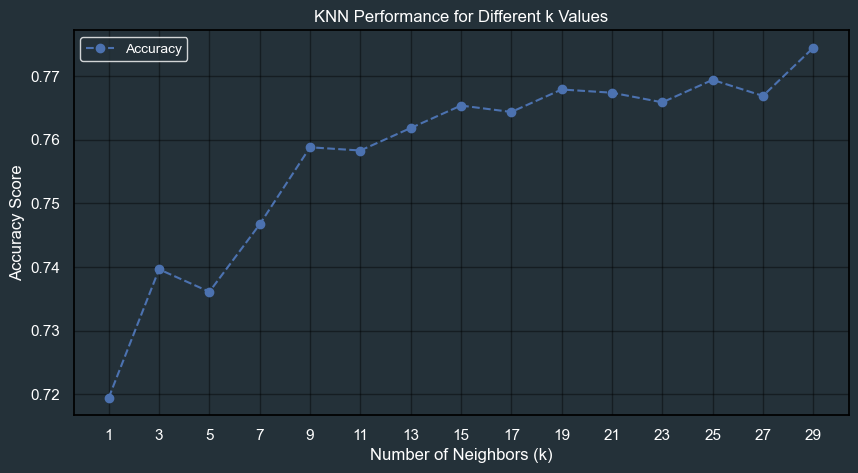

In [11]:
plt.figure(figsize=(10,5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b', label="Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance for Different k Values", color = 'white')
plt.xticks(k_values)
legend = plt.legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.show()

In [12]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=9), 
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=9),  
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(n_estimators= 250, max_depth= 6, learning_rate= 0.2873225418586847, subsample= 0.9948622677920532, colsample_bytree= 0.8730724543219378, gamma= 0.17988892114206567, reg_alpha= 0.020489343776532103, reg_lambda= 0.8638117996159738)
}

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model Training</p>

In [13]:
test_results = {}
train_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None  
    y_prob_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  
    train_results[name] = {
        "Accuracy": accuracy_score(y_train, y_pred_train),
        "Precision": classification_report(y_train, y_pred_train, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_train, y_pred_train, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_train, y_pred_train, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_train, y_prob_train) if y_prob_train is not None else None
    }
    test_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred_test),
        "Precision": classification_report(y_test, y_pred_test, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_test, y_pred_test, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_test, y_pred_test, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_test, y_prob_test) if y_prob_test is not None else None
    }
    

<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model Evaluation</p>

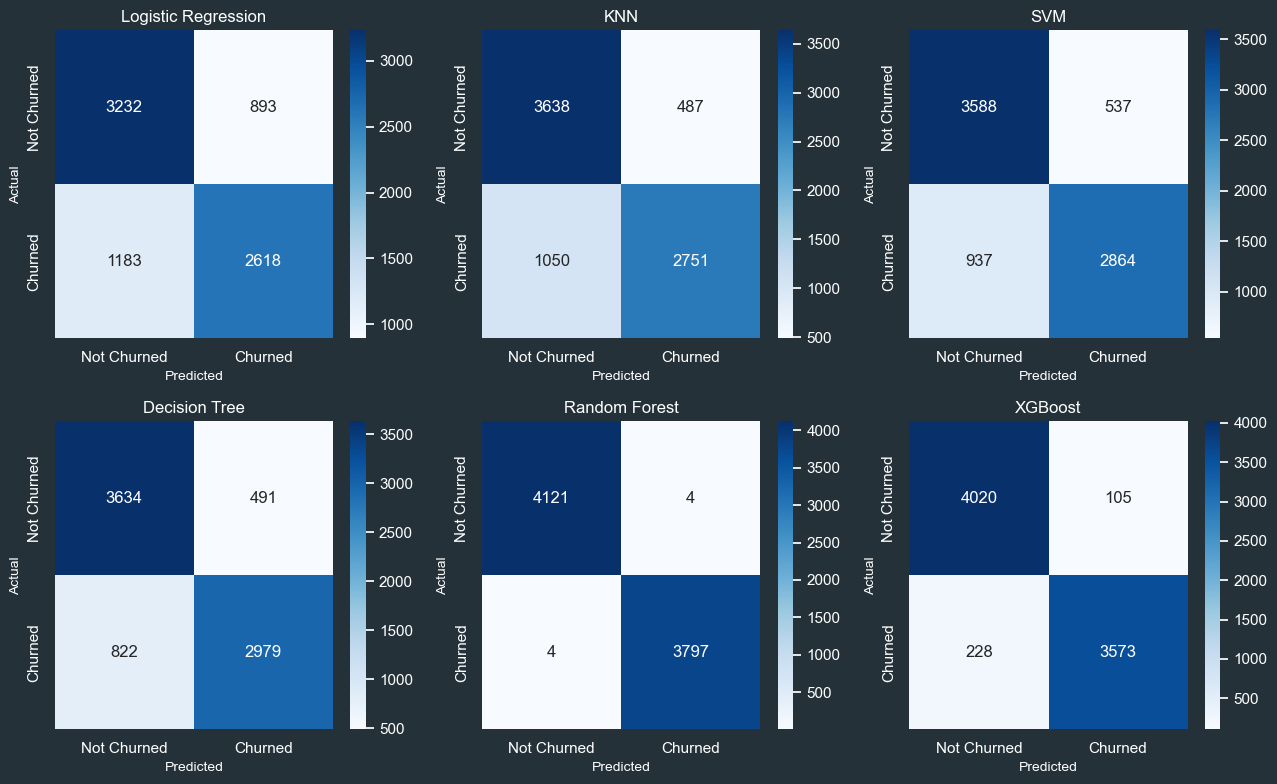

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))  
axes = axes.flatten()
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=["Not Churned", "Churned"], 
                yticklabels=["Not Churned", "Churned"], ax=axes[i])
    
    axes[i].set_title(name, fontsize=12, color= 'white')
    axes[i].set_xlabel("Predicted", fontsize=10)
    axes[i].set_ylabel("Actual", fontsize=10)
plt.tight_layout()
plt.show()


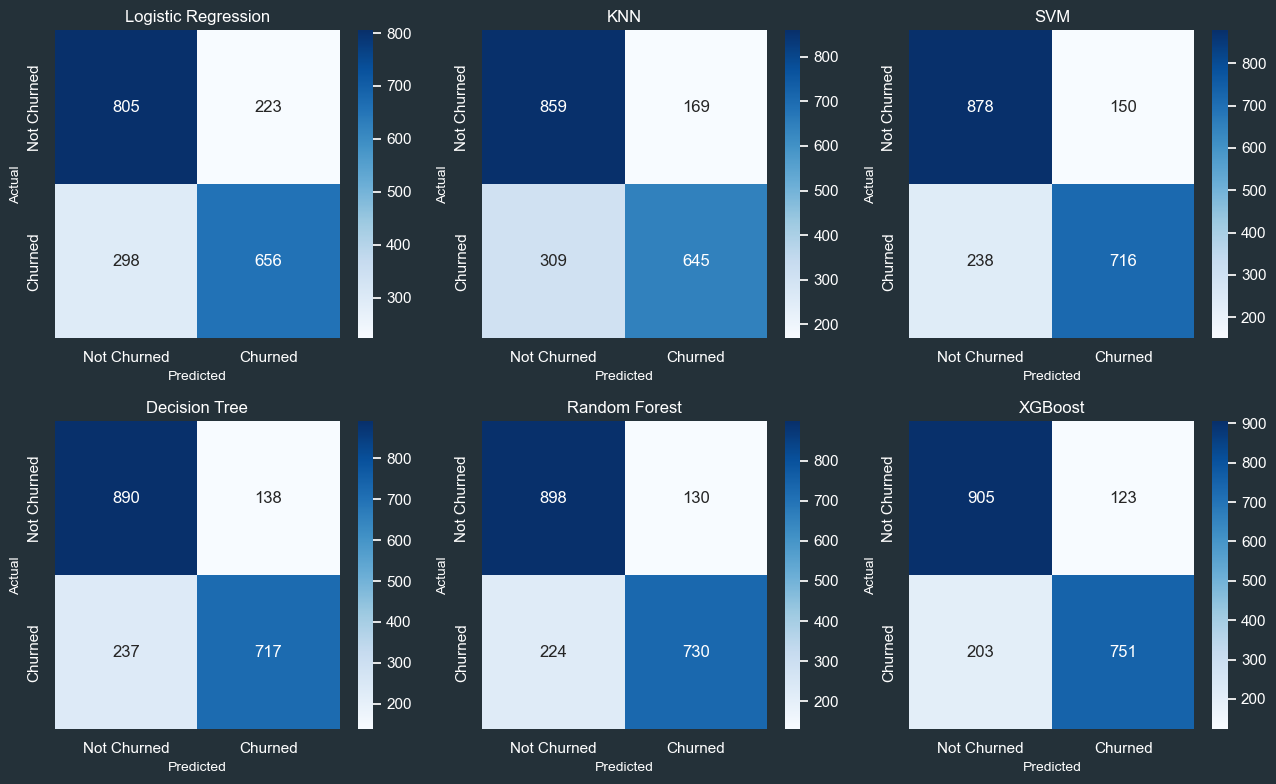

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))  
axes = axes.flatten()
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=["Not Churned", "Churned"], 
                yticklabels=["Not Churned", "Churned"], ax=axes[i])
    
    axes[i].set_title(name, fontsize=12, color= 'white')
    axes[i].set_xlabel("Predicted", fontsize=10)
    axes[i].set_ylabel("Actual", fontsize=10)
plt.tight_layout()  
plt.show()


In [16]:
df_results_train = pd.DataFrame(train_results).T
print("   Train Results")
print(df_results_train)


   Train Results
                     Accuracy  Precision    Recall  F1-score   ROC-AUC
Logistic Regression  0.738077   0.745657  0.688766  0.716083  0.810321
KNN                  0.806081   0.849599  0.723757  0.781645  0.893916
SVM                  0.814030   0.842105  0.753486  0.795335  0.890661
Decision Tree        0.834343   0.858501  0.783741  0.819420  0.918497
Random Forest        0.998991   0.998948  0.998948  0.998948  0.999997
XGBoost              0.957986   0.971452  0.940016  0.955475  0.993229


In [17]:
df_results_test = pd.DataFrame(test_results).T
print("   Test Results")
print(df_results_test)


   Test Results
                     Accuracy  Precision    Recall  F1-score   ROC-AUC
Logistic Regression  0.737134   0.746303  0.687631  0.715767  0.806523
KNN                  0.758829   0.792383  0.676101  0.729638  0.843965
SVM                  0.804238   0.826790  0.750524  0.786813  0.883052
Decision Tree        0.810797   0.838596  0.751572  0.792703  0.897128
Random Forest        0.821393   0.848837  0.765199  0.804851  0.908828
XGBoost              0.835520   0.859268  0.787212  0.821663  0.921232


<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model Comparison</p>

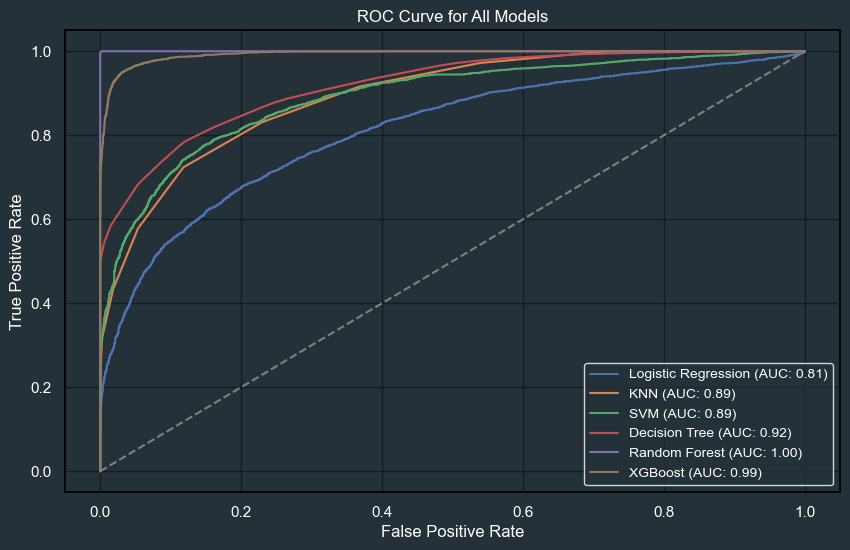

In [18]:

plt.figure(figsize=(10,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC: {roc_auc_score(y_train, y_prob):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models", color = 'white')
legend = plt.legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.show()


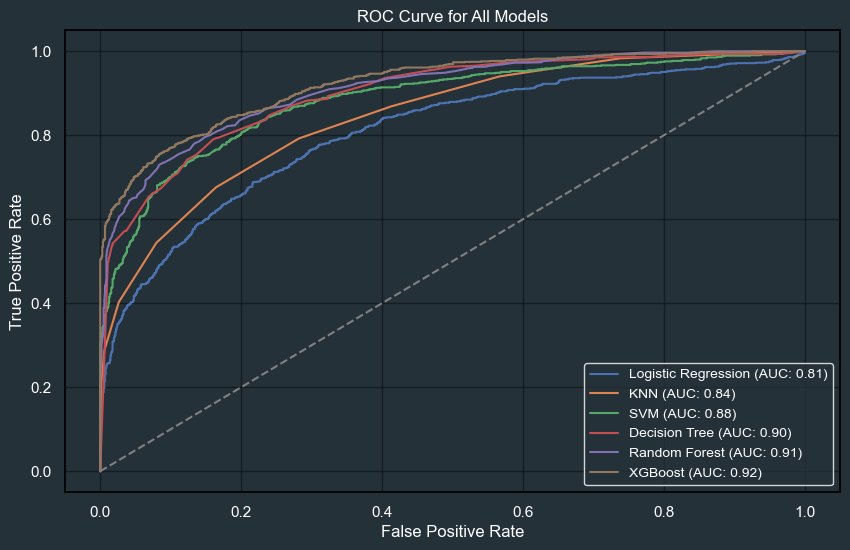

In [19]:

plt.figure(figsize=(10,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC: {roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models", color = 'white')
legend = plt.legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.show()


<Figure size 1200x600 with 0 Axes>

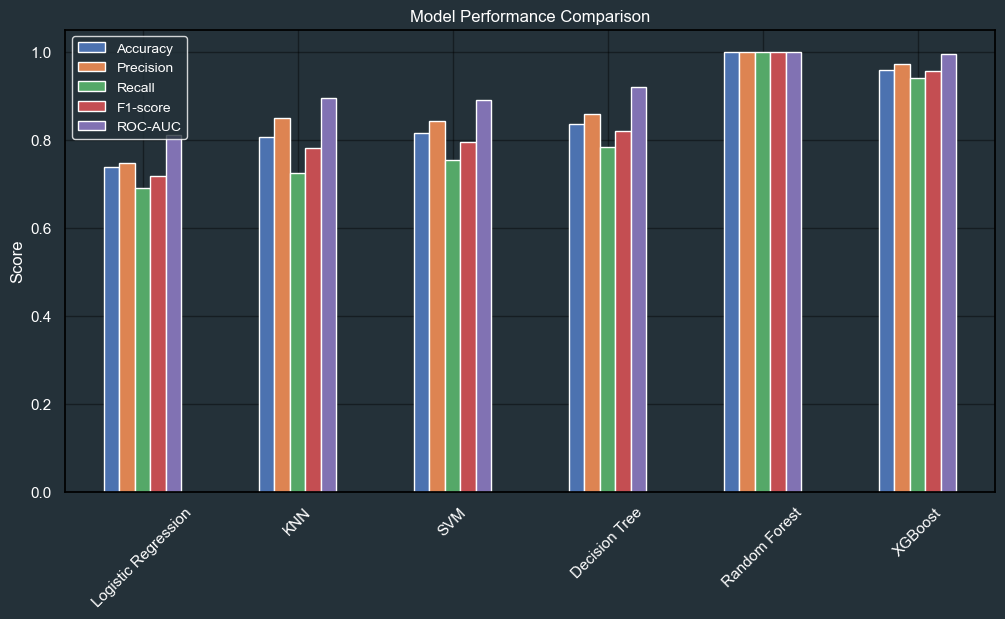

In [20]:
plt.figure(figsize=(12,6))
df_results_train.plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison", color = 'white')
plt.ylabel("Score")
plt.xticks(rotation=45)
legend = plt.legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.show()


<Figure size 1200x600 with 0 Axes>

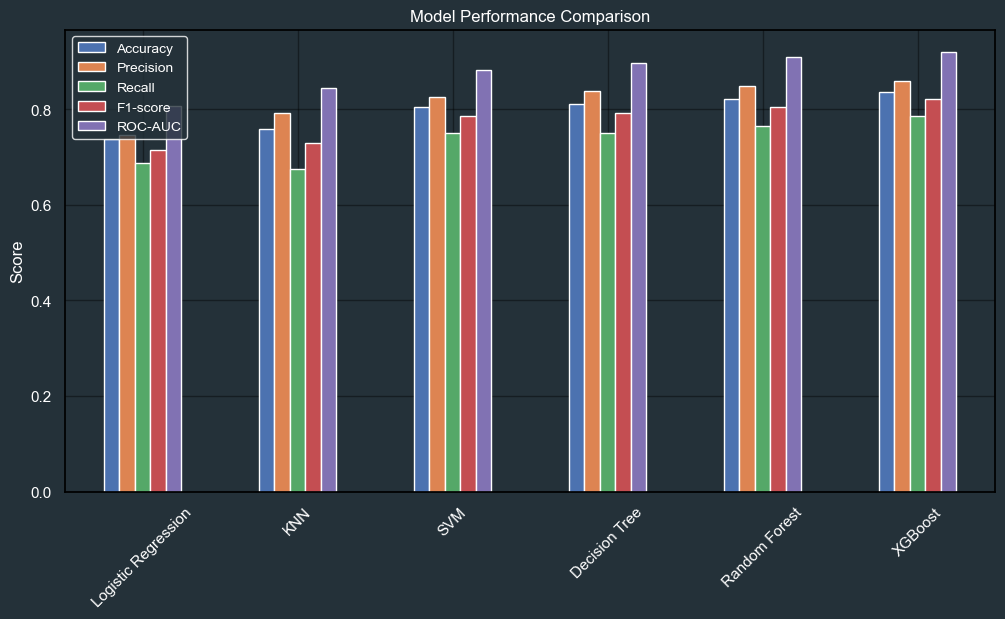

In [21]:
plt.figure(figsize=(12,6))
df_results_test.plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison", color = 'white')
plt.ylabel("Score")
plt.xticks(rotation=45)
legend = plt.legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.show()


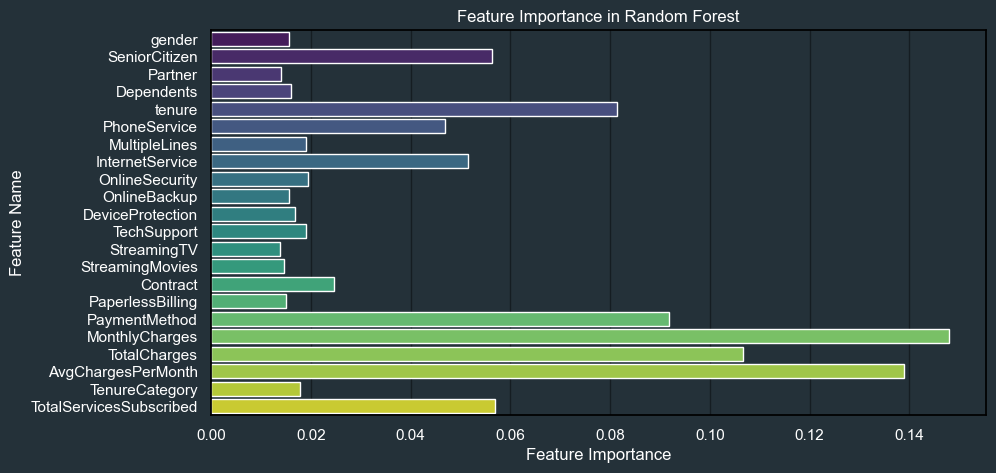

In [22]:
importances = models["Random Forest"].feature_importances_  
features = X_train.columns
plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Random Forest", color = 'white')
plt.show()


<a id="4"></a>
# <p style="background-color:#001f3f;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Hyperparameter Tuning</p>

In [23]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=10, n_classes=2, random_state=42)

model_type = "random_forest" 

def objective(trial):
    if model_type == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2),
        }
        model = XGBClassifier(**params, objective='binary:logistic', random_state=42)
        
    elif model_type == "random_forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        }
        model = RandomForestClassifier(**params, random_state=42)

    score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    
    return score.mean()  
rf = optuna.create_study(direction="maximize") 
rf.optimize(objective, n_trials=50)

print("Best trial:")
print(rf.best_trial)
print("Best params:", rf.best_trial.params)


[I 2025-05-09 19:39:16,247] A new study created in memory with name: no-name-10422b65-5759-432e-9e9d-c87d86e26eab
[I 2025-05-09 19:39:20,210] Trial 0 finished with value: 0.944 and parameters: {'n_estimators': 332, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.944.
[I 2025-05-09 19:39:26,890] Trial 1 finished with value: 0.9480000000000001 and parameters: {'n_estimators': 323, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9480000000000001.
[I 2025-05-09 19:39:38,406] Trial 2 finished with value: 0.9359999999999999 and parameters: {'n_estimators': 422, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9480000000000001.
[I 2025-05-09 19:39:42,151] Trial 3 finished with value: 0.9359999999999999 and parameters: {'n_estimators': 167, 'max_depth': 8, 'min_samples_split': 9, 'min_s

Best trial:
FrozenTrial(number=10, state=1, values=[0.952], datetime_start=datetime.datetime(2025, 5, 9, 19, 40, 24, 852863), datetime_complete=datetime.datetime(2025, 5, 9, 19, 40, 29, 675868), params={'n_estimators': 243, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=5, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=10, value=None)
Best params: {'n_estimators': 243, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [24]:
model_type = "xgboost" 

xgb = optuna.create_study(direction="maximize") 
xgb.optimize(objective, n_trials=50)

print("Best trial:")
print(xgb.best_trial)
print("Best params:", xgb.best_trial.params)

[I 2025-05-09 19:43:57,896] A new study created in memory with name: no-name-b1f64c4f-4e34-41c7-97ae-03fbf71f5b95
[I 2025-05-09 19:44:01,930] Trial 0 finished with value: 0.932 and parameters: {'n_estimators': 358, 'max_depth': 12, 'learning_rate': 0.16223147535499904, 'subsample': 0.7946440778593591, 'colsample_bytree': 0.5505249817594422, 'gamma': 2.4769934573011616, 'reg_alpha': 0.8928730556349487, 'reg_lambda': 0.9341044005820459}. Best is trial 0 with value: 0.932.
[I 2025-05-09 19:44:19,174] Trial 1 finished with value: 0.96 and parameters: {'n_estimators': 455, 'max_depth': 10, 'learning_rate': 0.012384377947627877, 'subsample': 0.9875665651458, 'colsample_bytree': 0.8018926171384212, 'gamma': 0.4527244637242306, 'reg_alpha': 0.9447816767802969, 'reg_lambda': 1.3308499331653718}. Best is trial 1 with value: 0.96.
[I 2025-05-09 19:44:23,115] Trial 2 finished with value: 0.944 and parameters: {'n_estimators': 318, 'max_depth': 7, 'learning_rate': 0.11541828833682077, 'subsample': 

Best trial:
FrozenTrial(number=1, state=1, values=[0.96], datetime_start=datetime.datetime(2025, 5, 9, 19, 44, 1, 931229), datetime_complete=datetime.datetime(2025, 5, 9, 19, 44, 19, 173119), params={'n_estimators': 455, 'max_depth': 10, 'learning_rate': 0.012384377947627877, 'subsample': 0.9875665651458, 'colsample_bytree': 0.8018926171384212, 'gamma': 0.4527244637242306, 'reg_alpha': 0.9447816767802969, 'reg_lambda': 1.3308499331653718}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDistribution(high=1.0, log=Fals

In [25]:
rf_best_params = rf.best_trial.params

model = RandomForestClassifier(**rf_best_params)

model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None  
rf_results_train = {
        "Accuracy": accuracy_score(y_train, predictions_train),
        "Precision": classification_report(y_train, predictions_train, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_train, predictions_train, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_train, predictions_train, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_train, y_prob_train) if y_prob_train is not None else None
}
predictions_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  
rf_results_test = {
        "Accuracy": accuracy_score(y_test, predictions_test),
        "Precision": classification_report(y_test, predictions_test, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_test, predictions_test, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_test, predictions_test, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_test, y_prob_test) if y_prob_train is not None else None
}
print("Random Forest Train Results           Random Forest Test Results  ")
print()
for i in rf_results_train.keys():
        print(f"{i} : {rf_results_train[i]}         {i} : {rf_results_test[i]}")

Random Forest Train Results           Random Forest Test Results  

Accuracy : 0.9823366136765077         Accuracy : 0.8249243188698284
Precision : 0.9916733816814397         Precision : 0.8492520138089759
Recall : 0.9713233359642199         Recall : 0.7735849056603774
F1-score : 0.9813928761297183         F1-score : 0.8096544157981349
ROC-AUC : 0.9992985577957954         ROC-AUC : 0.9123815146546589


In [26]:
xgb_best_params = xgb.best_trial.params

model = XGBClassifier(**xgb_best_params)

model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None  
xgb_results_train = {
        "Accuracy": accuracy_score(y_train, predictions_train),
        "Precision": classification_report(y_train, predictions_train, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_train, predictions_train, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_train, predictions_train, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_train, y_prob_train) if y_prob_train is not None else None
}
predictions_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  
xgb_results_test = {
        "Accuracy": accuracy_score(y_test, predictions_test),
        "Precision": classification_report(y_test, predictions_test, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_test, predictions_test, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_test, predictions_test, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_test, y_prob_test) if y_prob_train is not None else None
}
print("XGboost Train Results                 XGboost Test Results  ")
print()
for i in rf_results_train.keys():
        print(f"{i} : {xgb_results_train[i]}         {i} : {xgb_results_test[i]}")

XGboost Train Results                 XGboost Test Results  

Accuracy : 0.9017158718142821         Accuracy : 0.8370332996972755
Precision : 0.929749715585893         Precision : 0.8672875436554133
Recall : 0.860036832412523         Recall : 0.7809224318658281
F1-score : 0.8935356020226869         F1-score : 0.821842250413679
ROC-AUC : 0.9707460716079501         ROC-AUC : 0.9247990235665516


In [27]:
from sklearn.ensemble import StackingClassifier
stacking = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(**rf_best_params)),
    ('xgb', XGBClassifier(**xgb_best_params))
], final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=29,
                                                       min_samples_split=5,
                                                       n_estimators=243)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8018926171384212,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_typ...
                                              interaction_constraints=None,
                                              learning_rate=0.012384377947627877,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=455, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [28]:
predictions_train = stacking.predict(X_train)
y_prob_train = stacking.predict_proba(X_train)[:, 1] if hasattr(stacking, "predict_proba") else None  
stacking_results_train = {
        "Accuracy": accuracy_score(y_train, predictions_train),
        "Precision": classification_report(y_train, predictions_train, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_train, predictions_train, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_train, predictions_train, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_train, y_prob_train) if y_prob_train is not None else None
}
predictions_test = stacking.predict(X_test)
y_prob_test = stacking.predict_proba(X_test)[:, 1] if hasattr(stacking, "predict_proba") else None  
stacking_results_test = {
        "Accuracy": accuracy_score(y_test, predictions_test),
        "Precision": classification_report(y_test, predictions_test, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_test, predictions_test, output_dict=True)["1"]["recall"],
        "F1-score": classification_report(y_test, predictions_test, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_test, y_prob_test) if y_prob_train is not None else None
}
print("Stacking Train Results                 Stacking Test Results  ")
print()
for i in rf_results_train.keys():
        print(f"{i} : {stacking_results_train[i]}         {i} : {stacking_results_test[i]}")

Stacking Train Results                 Stacking Test Results  

Accuracy : 0.9231642694928085         Accuracy : 0.8340060544904138
Precision : 0.9401544401544402         Precision : 0.8555176336746303
Recall : 0.8968692449355433         Recall : 0.7882599580712788
F1-score : 0.9180018850141376         F1-score : 0.8205128205128205
ROC-AUC : 0.9809093938596701         ROC-AUC : 0.9246144637773372


In [29]:
threshold = 0.1
y_pred_train = (y_prob_train >= threshold).astype(int)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
print("Train Results")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")
print()
y_pred_test = (y_prob_test >= threshold).astype(int)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print("Test Results")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

Train Results
Precision: 0.67, Recall: 1.00

Test Results
Precision: 0.64, Recall: 0.98


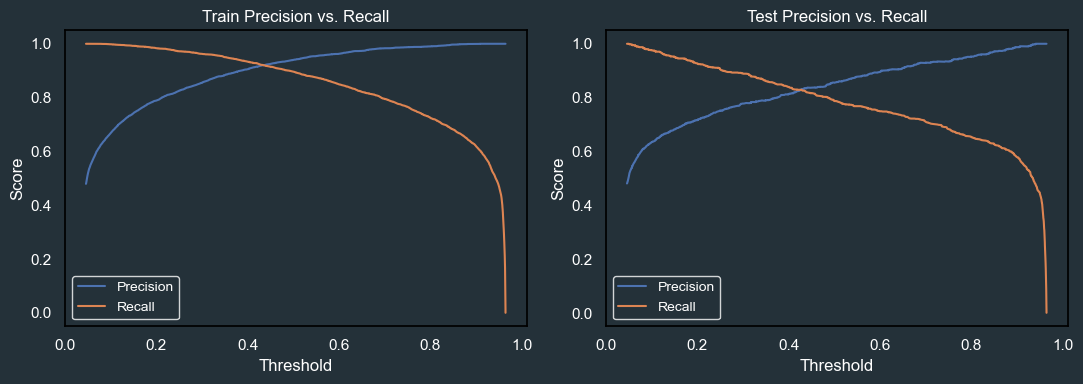

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4)) 
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train)

axes[0].plot(thresholds, precisions[:-1], label='Precision')
axes[0].plot(thresholds, recalls[:-1], label='Recall')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title("Train Precision vs. Recall", color = 'white')
legend = axes[0].legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
axes[0].grid()
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_test)

axes[1].plot(thresholds, precisions[:-1], label='Precision')
axes[1].plot(thresholds, recalls[:-1], label='Recall')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title("Test Precision vs. Recall", color = 'white')
legend = axes[1].legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.tight_layout()
axes[1].grid()
plt.show()


In [31]:
def categorize_churn(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.1:
        return 'Medium Risk'
    else:
        return 'Low Risk'

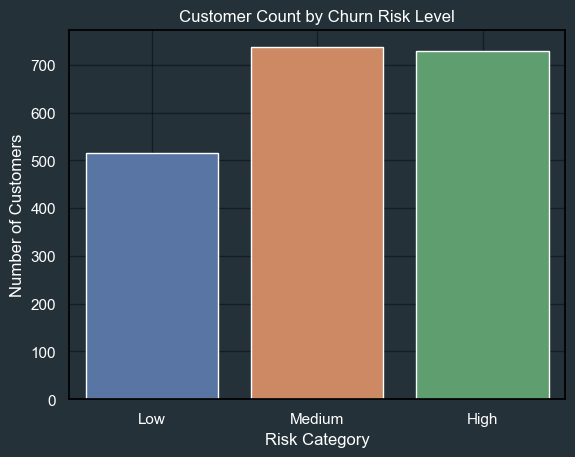

In [32]:
risk_categories = np.array([categorize_churn(p) for p in y_prob_test])
risk_series = pd.Series(risk_categories)
risk_numeric = risk_series.map({'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2})

sns.countplot(x=risk_numeric)
plt.xlabel('Risk Category')
plt.ylabel('Number of Customers')
plt.xticks([0,1,2],['Low', 'Medium', 'High'])
plt.title('Customer Count by Churn Risk Level', color= 'white')
plt.grid(True)
plt.show()

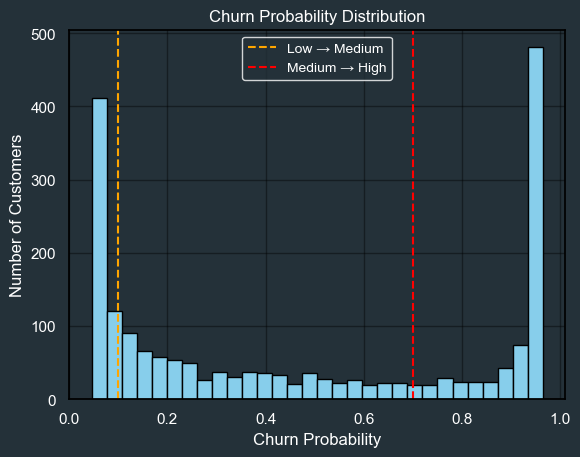

In [33]:
plt.hist(y_prob_test, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.1, color='orange', linestyle='--', label='Low → Medium')
plt.axvline(0.7, color='red', linestyle='--', label='Medium → High')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.title('Churn Probability Distribution', color= 'white')
legend = plt.legend(edgecolor='white', prop={'size':10})
plt.setp(legend.get_texts(), color="white")
plt.grid(True)
plt.show()

In [34]:
df = pd.DataFrame({
    'actual_churn': y_test,
    'churn_prob': y_prob_test
})

df['risk_category'] = pd.cut(df['churn_prob'],
                             bins=[0, 0.1, 0.7, 1.0],
                             labels=['Low Risk', 'Medium Risk', 'High Risk'])

churn_counts = df[df['actual_churn'] == 1].groupby('risk_category').size()

print(churn_counts)

risk_category
Low Risk        23
Medium Risk    253
High Risk      678
dtype: int64


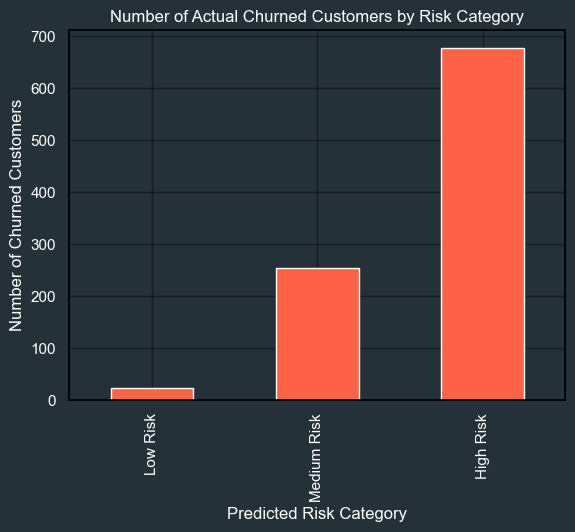

In [35]:
churn_counts.plot(kind='bar', color='tomato')
plt.title('Number of Actual Churned Customers by Risk Category', color= 'white')
plt.xlabel('Predicted Risk Category')
plt.ylabel('Number of Churned Customers')
plt.grid(True)
plt.show()


In [36]:
total_per_category = df.groupby('risk_category').size()

churned_per_category = df[df['actual_churn'] == 1].groupby('risk_category').size()

churn_rate = (churned_per_category / total_per_category * 100).round(2)

print(churn_rate)


risk_category
Low Risk        4.46
Medium Risk    34.33
High Risk      93.00
dtype: float64


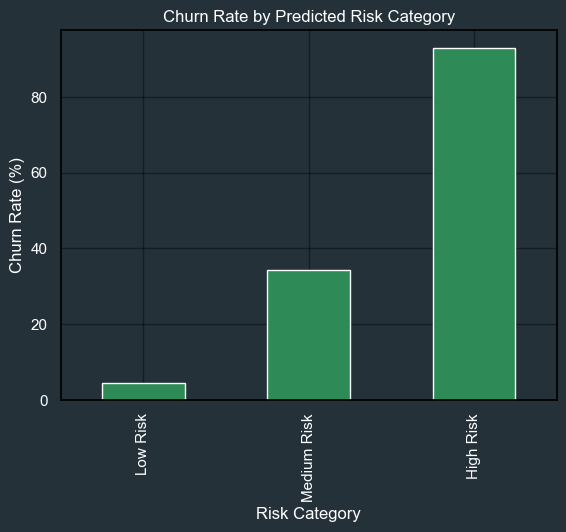

In [37]:
churn_rate.plot(kind='bar', color='seagreen')
plt.title('Churn Rate by Predicted Risk Category', color= 'white')
plt.xlabel('Risk Category')
plt.ylabel('Churn Rate (%)')
plt.grid(True)
plt.show()


In [38]:
import mlflow
mlflow.set_experiment("Basic_ML_Tracking")

<Experiment: artifact_location='file:///c:/Users/laptop%20shop/Desktop/ML%20Project/mlruns/209191552070180540', creation_time=1746592984293, experiment_id='209191552070180540', last_update_time=1746592984293, lifecycle_stage='active', name='Basic_ML_Tracking', tags={}>

2025/05/09 19:50:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.7185 | F1: 0.7694 | Recall: 0.9759 | Precision: 0.6351


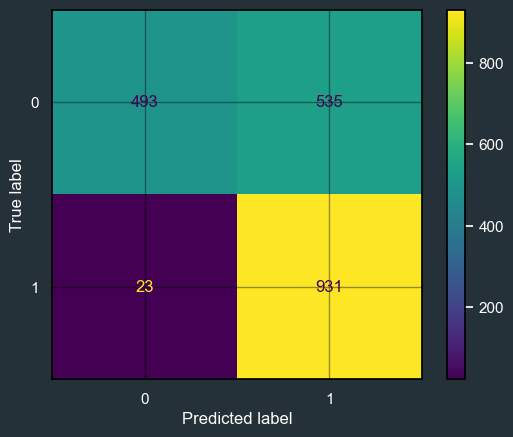

In [41]:
import mlflow.sklearn

with mlflow.start_run(run_name="stacking_ensemble_run"):

    mlflow.set_tag("model_type", "stacking_ensemble")

    mlflow.log_param("base_estimators", [est[0] for est in stacking.estimators])
    mlflow.log_param("final_estimator", stacking.final_estimator.__class__.__name__)

    if hasattr(stacking.final_estimator, 'n_estimators'):
        mlflow.log_param("meta_n_estimators", stacking.final_estimator.n_estimators)

    predictions = (y_prob_test >= threshold).astype(int)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    mlflow.sklearn.log_model(stacking, "stacking_model")

    mlflow.log_param("threshold", threshold)

    from sklearn.metrics import ConfusionMatrixDisplay

    disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    disp.figure_.savefig("Image/confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    print(f"Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f}")


In [43]:
import joblib
joblib.dump(model, "Model/stacking_model.pkl")


['Model/stacking_model.pkl']